<a href="https://colab.research.google.com/github/eduardogranillo/FisicaComputacional/blob/master/Evaluacion1/Evaluacion1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Física Computacional**

**Evaluación 1**

**Eduardo Granillo Luna**


# Parte 1. Construcción de una Serie de Tiempo. 



In [1]:
# Importamos las bibliotecas a utilizar

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import pandas.util.testing as tm

# Bibliotecas para el análisis de Series de Tiempo y Modelos de Pronóstico
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf, pacf

# Suprimir mensajes de alertas de cambios futuros
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Matplotlib mostrará los resultados de la Notebook en la Jupyter
%matplotlib inline

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  


In [49]:
# Concentración de las operaciones de dataframe

# Tomar la dirección URL del archivo raw
url = 'https://raw.githubusercontent.com/carloslizarragac/FisicaComputacional1/master/Eval1/data/co2_spo_DailyData.txt'

# Definimos los nombres de las columnas
# El separador de datos es de uno o más espacios, sep='\s+'
# Se brincará los primeros 151 renglones, afirmamos que no hay encabezado
# Se provesan los datos utilizando Python, engine='python'
my_cols = ['site_code', 'year', 'month','day', 'hour', 
           'minute','second', ' time_decimal', 'value',
           'value_std_dev', 'nvalue ','  latitude','longitude',
           'altitude ', 'elevation', 'intake_height', 'qcflag']
df_dist = pd.read_csv(url, names=my_cols, sep='\s+', header=None, skiprows=151, engine='python')

# Hacemos una copia de trabajo y preservamos el dataframe original
df_work0 = df_dist.copy()

# Reemplazamos los números '-999.99' por espacio en blanco ''
str_999 = -999.99
df_work1 = df_work0.replace(to_replace=str_999, value='', regex=True)

# Deseamos convertir los valores de las variables a núm flotantes
df_work1['value'] = pd.to_numeric(df_work1['value'], errors='coerce')

# Volvemos a hacer una pausa y definimos un nuevo dataframe por si hay que regresarse.
df_work2 = df_work1.copy()

# Pandas tiene la función pd.to_datetime que convierte una cadena en tipo datetime64[ns]
df = pd.DataFrame({'day':df_work2['day'], 
                         'month':df_work2['month'],
                         'year':df_work2['year']})
df_work2['Fecha']=pd.to_datetime(df).copy()

# Hacemos copia
df_co_ts=df_work2.copy()

# Redefinimos el índice del DataFrame a que sea la variable 'Fecha'
df_co_ts = df_co_ts.set_index('Fecha')

# Verificamos que haya salido bien
df_co_ts.info()
print(df_co_ts.head())
print(df_co_ts.tail())
# df_co_ts

# Seleccionaremos un conjunto de años de 30 años  
df_80 = df_co_ts[(df_co_ts['year'] >= 1980) & (df_co_ts['year'] < 2020)]

# Para que solo contenga la columna value
df_80 = df_80['value']
# Función para rellenar hacia enfrente los valores vacíos en base al último valor anterior disponible. 
df_80.ffill(axis = 0, inplace=True) 
#df_80
print(df_80.head())
print(df_80.tail())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 16436 entries, 1975-01-01 to 2019-12-31
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   site_code      16436 non-null  object 
 1   year           16436 non-null  int64  
 2   month          16436 non-null  int64  
 3   day            16436 non-null  int64  
 4   hour           16436 non-null  int64  
 5   minute         16436 non-null  int64  
 6   second         16436 non-null  int64  
 7    time_decimal  16436 non-null  float64
 8   value          15276 non-null  float64
 9   value_std_dev  16436 non-null  float64
 10  nvalue         16436 non-null  int64  
 11    latitude     16436 non-null  float64
 12  longitude      16436 non-null  float64
 13  altitude       16436 non-null  float64
 14  elevation      16436 non-null  float64
 15  intake_height  16436 non-null  float64
 16  qcflag         16436 non-null  object 
dtypes: float64(8), int64(7), object(2

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


In [50]:
# Creamos la primer serie de Tiempo para analizar, 
# haciendo una copia de la epoca de 1980 a 2019 
# o el periodo que se desee. Podemos regresar a esta punto las veces que se requiera definir

# Fechas de inicio y fin, para filtrar la información
start, end = '1980-01', '2019-12'

ts_80 = df_80.loc[start:end].copy()
ts_80.head(25)

Fecha
1980-01-01    336.30
1980-01-02    336.28
1980-01-03    336.21
1980-01-04    336.19
1980-01-05    336.20
1980-01-06    336.12
1980-01-07    336.01
1980-01-08    336.16
1980-01-09    336.18
1980-01-10    336.17
1980-01-11    336.16
1980-01-12    336.17
1980-01-13    336.12
1980-01-14    336.09
1980-01-15    335.88
1980-01-16    335.99
1980-01-17    335.92
1980-01-18    335.94
1980-01-19    336.26
1980-01-20    336.27
1980-01-21    336.12
1980-01-22    336.17
1980-01-23    336.16
1980-01-24    336.17
1980-01-25    336.20
Name: value, dtype: float64

In [59]:
ts_80

Fecha
1980-01-01    336.30
1980-01-02    336.28
1980-01-03    336.21
1980-01-04    336.19
1980-01-05    336.20
               ...  
2019-12-27    409.06
2019-12-28    409.00
2019-12-29    408.70
2019-12-30    408.41
2019-12-31    408.57
Name: value, Length: 14610, dtype: float64

In [51]:
ts_80.isnull().sum()

0

# Parte 2. Análisis de la Serie de Tiempo.


*   Define una función para probar estacionaridad utilizando la Prueba Avanzada de Dickey-Fuller: test_stationarity(df_ts)




In [34]:
# Función para probar la estacionaridad de una serie de tiempo: 'timeseries'
   
def test_stationarity(df_ts):
    
    #Determinar la Estadística de promedios móviles
    rolmean = df_ts.rolling(window=365, center=True).mean()
    rolstd = df_ts.rolling(window=365, center=True).std() 
    
    # Define el tamaño de la figura
    plt.rcParams["figure.figsize"] = (12,6)

    #Graficar la Estadística de promedios móviles 
    plt.plot(df_ts, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std Deviation')
 
    plt.legend(loc='best')
    plt.title('Promedio Móvil y Desviación Estándar')
    plt.grid()
    plt.show()
 
    #Realiza la Prueba Aumentada de  Dickey-Fuller:
    print('Resultados de la Prueba de Dickey-Fuller:')
    dftest = adfuller(df_ts, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], 
                         index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

*   Prueba la estacionaridad de tu serie de tiempo 'ts_test' en base al valor p.




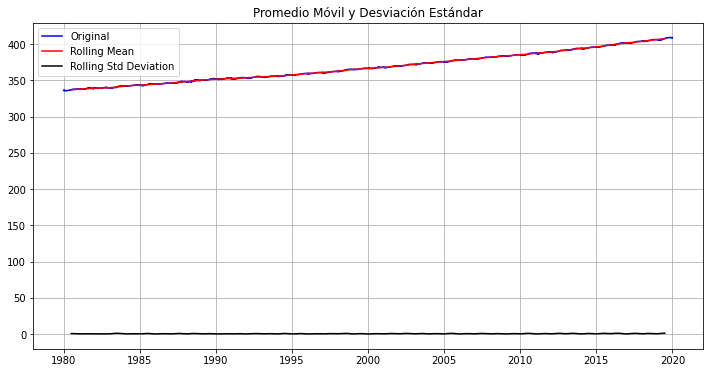

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                     0.973933
p-value                            0.993983
#Lags Used                        42.000000
Number of Observations Used    14567.000000
Critical Value (1%)               -3.430799
Critical Value (5%)               -2.861738
Critical Value (10%)              -2.566876
dtype: float64


In [35]:
test_stationarity(ts_80)

* Si no es una serie de tiempo estacionaria, cambia de escala a Log(CO2), y gráfica la nueva función. 


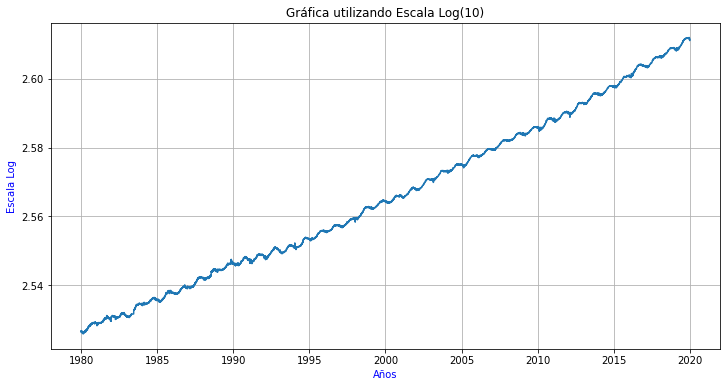

In [36]:
# Seleccionamos la función logaritmo (base 10) y graficamos (La escala en eje-y es Log)

ts_test_log = np.log10(ts_80)
plt.plot(ts_test_log)
plt.xlabel('Años',color='b')
plt.ylabel('Escala Log',color='b')
plt.title('Gráfica utilizando Escala Log(10)')
plt.grid()
plt.show();

* Haz una descomposición estacional de la serie 'ts_test_log', usando interpolación, y promedio móvil de 365 días. Produce las gráficas de las series que la componen. Comenta la serie de tendencia (aumento de CO2), estacionalidad (dependencia de las estaciones del año) y residuo (el resto).  

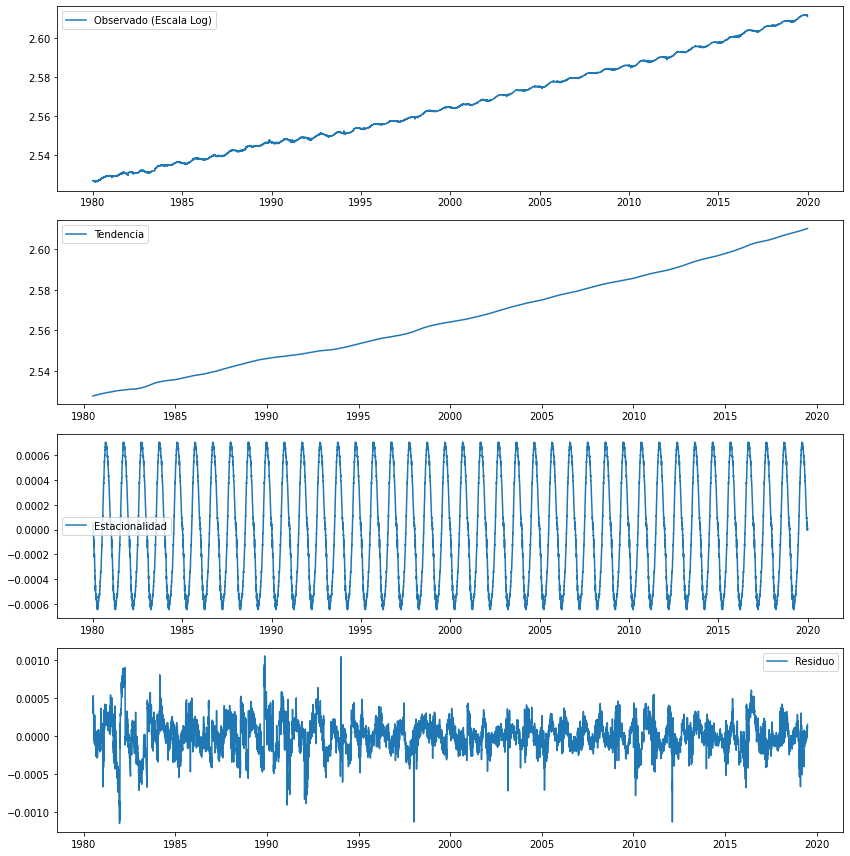

In [45]:
# Método de descomposición usando la biblioteca statsmodels.tsa

decomposition = sm.tsa.seasonal_decompose(ts_test_log.interpolate(), model='additive', freq=365)

# La función regresa 3 componentes: tendencia, estacionalidad y un residuo

trend = decomposition.trend
seasonal = decomposition.seasonal
residue = decomposition.resid

# Graficamos las componentes
plt.rcParams["figure.figsize"] = (12,12)
plt.subplot(411)
plt.plot(ts_test_log, label='Observado (Escala Log)')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Tendencia')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal, label='Estacionalidad')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residue, label='Residuo')
plt.legend(loc='best')

plt.tight_layout();

De estas gráficas se puede apreciar lo siguiente:

-En la observada (log) se ve el aumento y bajada respectivamente, pero aumento en general.

-En la tendencia se ve claramente el aumento de la concentración de CO2 a través de los años.

-En la de estacionalidad se aprecia muy constante en general, con las subidas y bajadas aproximadas a una función senoidal, lo que indica la estacionaridad ya que si hacemos un promedio quedará constante.

-El residuo se aprecia que es mayor al principio pero se va normalizando y también parece que el promedio es constante.



*  Prueba la estacionaridad de la serie residuo.  




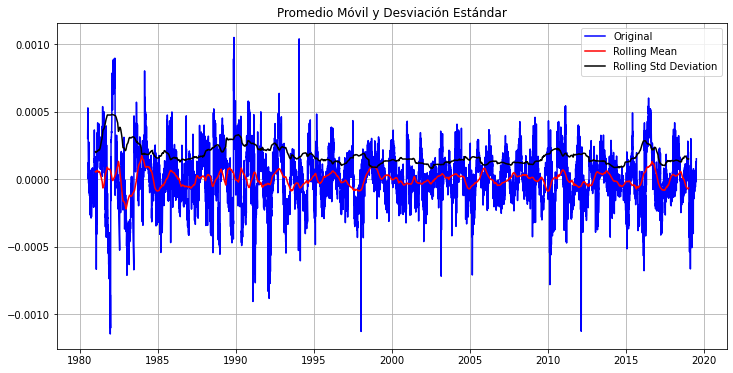

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                -1.135572e+01
p-value                        9.746288e-21
#Lags Used                     2.800000e+01
Number of Observations Used    1.421700e+04
Critical Value (1%)           -3.430810e+00
Critical Value (5%)           -2.861743e+00
Critical Value (10%)          -2.566878e+00
dtype: float64


In [43]:
# Eliminando la Tendencia y Estacionalidad, probamos si la serie Residuo es estacionaria o no...

ts_test_log_decompose = residue
ts_test_log_decompose.dropna(inplace=True)
test_stationarity(ts_test_log_decompose)

La p es menor a 5% por lo que el residuo se considera estacionario.

* Luego calcula un promedio móvil centrado sobre 'ts_test_log' usando un periodo de 365 días y contrastarlo en una gráfica con la serie de Log CO2.

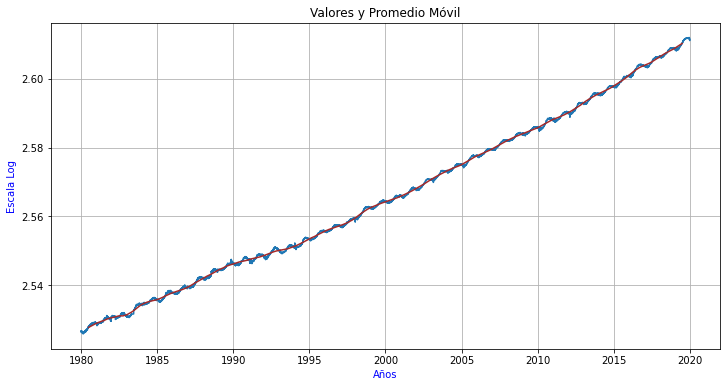

In [44]:
moving_avg = ts_test_log.rolling(365, center=True).mean()
plt.plot(ts_test_log)
plt.plot(moving_avg, color = 'brown')
plt.xlabel('Años',color='b')
plt.ylabel('Escala Log',color='b')
plt.title('Valores y Promedio Móvil')
plt.grid()
plt.show();

* Define un nuevo dataframe con la diferencia entre la serie logaritmo original y el promedio móvil, y prueba después su estacionaridad.

In [ ]:
ts_test_log_moving_ave_diff = ts_test_log - moving_avg 
ts_test_log_moving_ave_diff.head(10)

Fecha
1980-01-01   NaN
1980-01-02   NaN
1980-01-03   NaN
1980-01-04   NaN
1980-01-05   NaN
1980-01-06   NaN
1980-01-07   NaN
1980-01-08   NaN
1980-01-09   NaN
1980-01-10   NaN
Name: value, dtype: float64

In [ ]:
ts_test_log_moving_ave_diff.dropna(inplace=True)
ts_test_log_moving_ave_diff.head()

Fecha
1980-07-01    0.000184
1980-07-02    0.000229
1980-07-03    0.000249
1980-07-04    0.000255
1980-07-05    0.000313
Name: value, dtype: float64

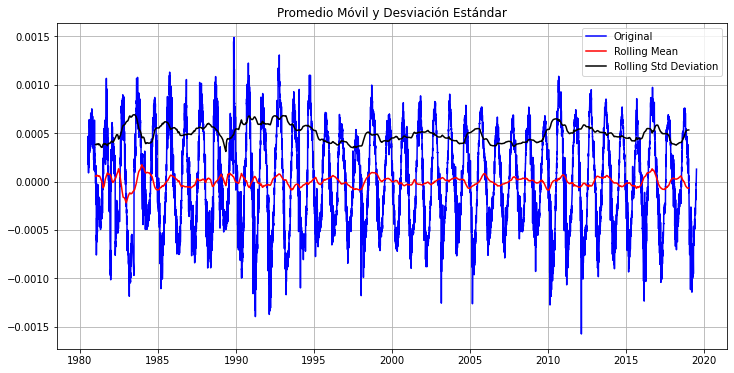

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                -1.135538e+01
p-value                        9.763779e-21
#Lags Used                     4.200000e+01
Number of Observations Used    1.420300e+04
Critical Value (1%)           -3.430811e+00
Critical Value (5%)           -2.861744e+00
Critical Value (10%)          -2.566878e+00
dtype: float64


In [ ]:
# Probamos ahora la estacionaridad de la nueva serie de tiempo escalada en Log
test_stationarity(ts_test_log_moving_ave_diff)

La p es menor a 5% por lo que los datos ahora son estacionarios.

* Adicionalmente, prueba construir una serie estacionaria usando la función de diferenciación shift con un periodo de 7 días, que utiliza menos puntos que el promedio móvil.  

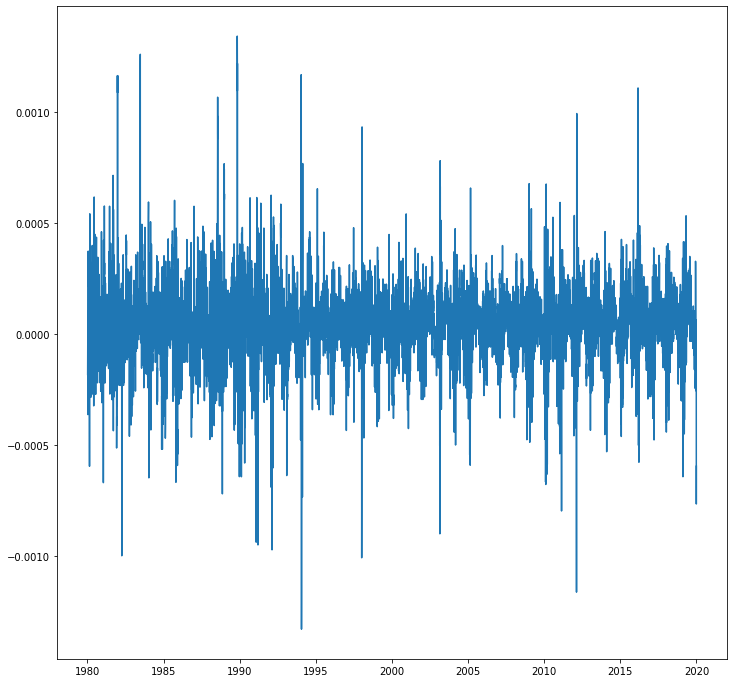

In [52]:
# Diferenciamos usando la función df.shift()
ts_test_log_diff = ts_test_log - ts_test_log.shift(periods=7)
plt.plot(ts_test_log_diff);

* Prueba la estacionaridad de esa última serie de tiempo 'ts_test_log_diff'.


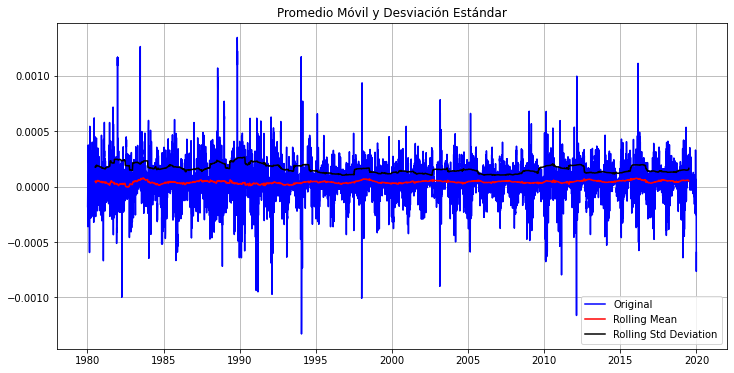

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                -1.171651e+01
p-value                        1.446943e-21
#Lags Used                     4.200000e+01
Number of Observations Used    1.456000e+04
Critical Value (1%)           -3.430799e+00
Critical Value (5%)           -2.861739e+00
Critical Value (10%)          -2.566876e+00
dtype: float64


In [53]:
# Probamos la estacionaridad
ts_test_log_diff.dropna(inplace=True)
test_stationarity(ts_test_log_diff)

In [54]:
# Número de datos utilizados
len(ts_test_log_diff)

14603

Vemos que si es estacionaria debido a que la p es menor al 5%.

* Construye un modelo ARIMA de la serie 'ts_test_log_diff', calculando los parámetros p, q y utiliza d=1 (ya que hemos ya derivado una vez)  

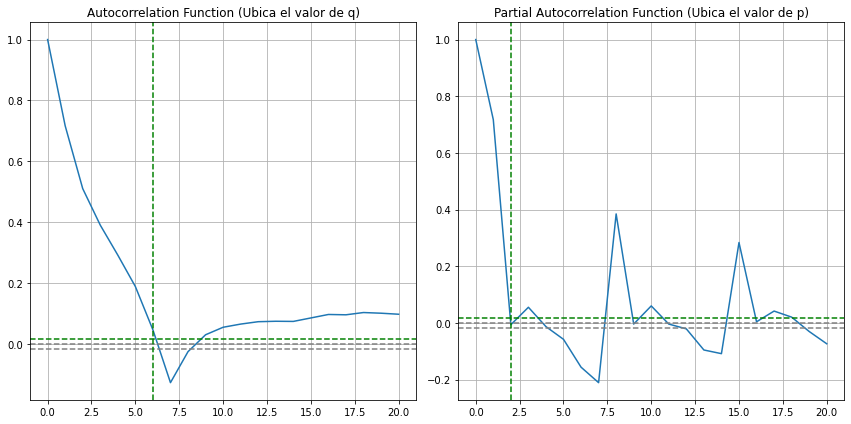

In [80]:
# Aplicamos ARIMA

lag_acf = acf(ts_test_log_diff, nlags=20)
lag_pacf = pacf(ts_test_log_diff, nlags=20, method = 'ols')

# Tamaño de las gráficas
plt.rcParams["figure.figsize"] = (12,6)

# Gráfica de ACF (Autocorrelation Function)
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_test_log_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_test_log_diff)), linestyle='--', color='green')
# Graficamos unas líneas verticales como referencias
#plt.axvline(x=3, linestyle='--', color='green')
plt.axvline(x=6, linestyle='--', color='green')
plt.grid()
plt.title('Autocorrelation Function (Ubica el valor de q)')

# Gráfica de PACF (Partial Autocorrelation Function)
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_test_log_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_test_log_diff)), linestyle='--', color='green')
# Graficamos unas líneas verticales como referencias 
plt.axvline(x=2, linestyle='--', color='green')
plt.grid()
plt.title('Partial Autocorrelation Function (Ubica el valor de p)')

plt.tight_layout()

Las líneas punteadas alrededor de cero representan los intervalos de confianza y nos serviran para determinar los valores p y q del modelo ARIMA.

p es donde cruza el PACF el primer nivel de confianza superior, que en la gráfica derecha es cercana a 2, por lo que p=2.

q es donde cruza la ACF el primer nivel de confianza superior, cercano a 4, por lo que haremos q=6.

Con estos dos valores construiremos los modelos ARIMA correspondientes.

* Para seleccionar el mejor modelo, calcula el Criterio de Información de Akaike (AIC) de los modelos: AR(p), MA(q), y ARIMA (p,d,q). 

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                D.value   No. Observations:                14609
Model:                 ARIMA(2, 1, 0)   Log Likelihood              116098.859
Method:                       css-mle   S.D. of innovations              0.000
Date:                Thu, 25 Feb 2021   AIC                        -232189.718
Time:                        06:01:03   BIC                        -232159.360
Sample:                    01-02-1980   HQIC                       -232179.632
                         - 12-31-2019                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const          5.788e-06   5.33e-07     10.851      0.000    4.74e-06    6.83e-06
ar.L1.D.value    -0.1522      0.008    -18.682      0.000      -0.168      -0.136
ar.L2.D.value    -0.1753      0.008    -

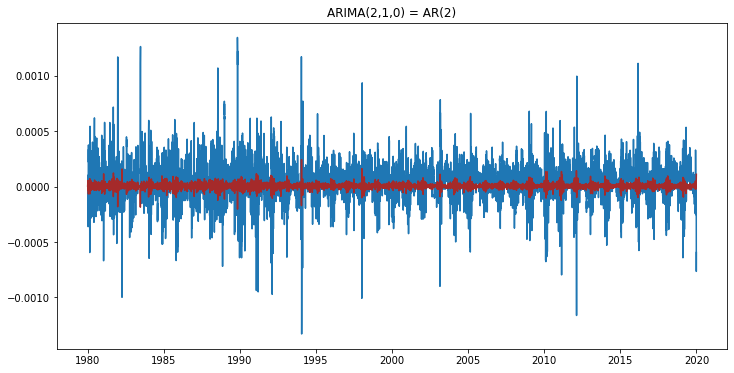

In [81]:
# Modelo AR(p): (p,d,q) = (2,1,0) 
model = ARIMA(ts_test_log, order=(2,1,0), missing='drop')
results_AR = model.fit(displ=-1)
plt.plot(ts_test_log_diff)
plt.plot(results_AR.fittedvalues, color='brown')
plt.title('ARIMA(2,1,0) = AR(2)')
print(results_AR.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                D.value   No. Observations:                14609
Model:                 ARIMA(0, 1, 6)   Log Likelihood              115820.123
Method:                       css-mle   S.D. of innovations              0.000
Date:                Thu, 25 Feb 2021   AIC                        -231624.247
Time:                        06:02:20   BIC                        -231563.532
Sample:                    01-02-1980   HQIC                       -231604.076
                         - 12-31-2019                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const          5.815e-06   2.44e-07     23.850      0.000    5.34e-06    6.29e-06
ma.L1.D.value    -0.1786      0.009    -20.393      0.000      -0.196      -0.161
ma.L2.D.value    -0.2081      0.008    -

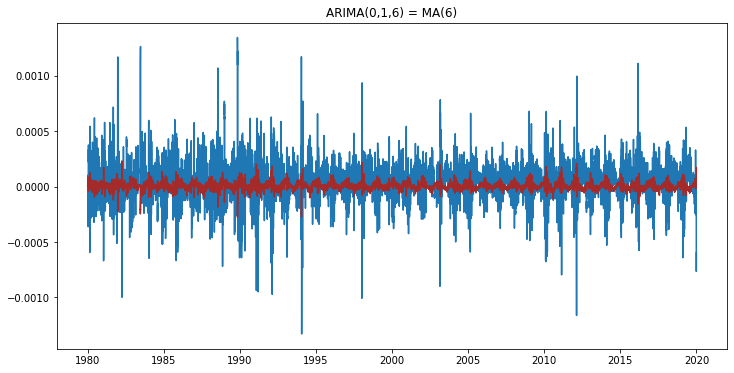

In [84]:
# Modelo MA(q): (p,d,q) = (0,1,6) 
model = ARIMA(ts_test_log, order=(0,1,6), missing='drop')
results_MA = model.fit(displ=-1)
plt.plot(ts_test_log_diff)
plt.plot(results_MA.fittedvalues, color='brown')
plt.title('ARIMA(0,1,6) = MA(6)')
print(results_MA.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:1441: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(-inv(hess)))


                             ARIMA Model Results                              
Dep. Variable:                D.value   No. Observations:                14609
Model:                 ARIMA(2, 1, 6)   Log Likelihood              116209.927
Method:                       css-mle   S.D. of innovations              0.000
Date:                Thu, 25 Feb 2021   AIC                        -232399.855
Time:                        06:02:45   BIC                        -232323.961
Sample:                    01-02-1980   HQIC                       -232374.642
                         - 12-31-2019                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const          5.795e-06   4.18e-07     13.861      0.000    4.98e-06    6.61e-06
ar.L1.D.value     0.3648        nan        nan        nan         nan         nan
ar.L2.D.value    -0.6854      0.094     

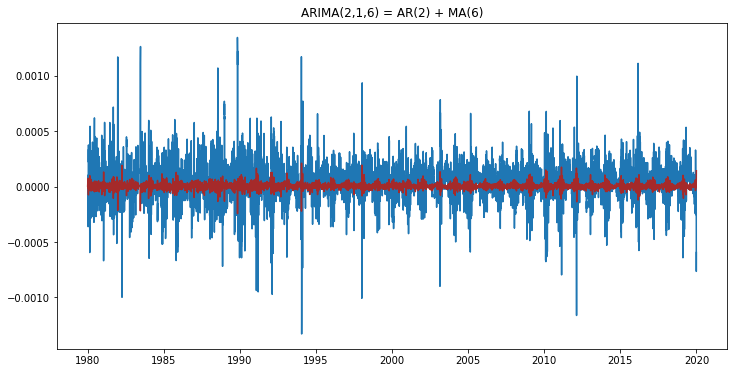

In [85]:
# Modelo ARIMA(p): (p,d,q) = (2,1,6) 
model = ARIMA(ts_test_log, order=(2,1,6), missing='drop')
results_ARIMA = model.fit(displ=-1)
plt.plot(ts_test_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='brown')
plt.title('ARIMA(2,1,6) = AR(2) + MA(6)')
print(results_ARIMA.summary())

Entre ellos se encuentra el criterio AIC.

ARIMA(2,1,0): AIC = -232189.718

ARIMA(0,1,6): AIC = -231624.247

ARIMA(2,1,4): AIC = -232399.855 <- Es el menor AIC

Podemos afirmar que ARIMA(2,1,4) es el mejor modelo de los 3 que exploramos.

In [87]:
# Definimos una serie de tiempo con las predicciones obtenidas por el método ARIMA
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(predictions_ARIMA_diff)

Fecha
1980-01-02    0.000006
1980-01-03    0.000010
1980-01-04    0.000026
1980-01-05    0.000032
1980-01-06    0.000022
                ...   
2019-12-27    0.000004
2019-12-28    0.000018
2019-12-29    0.000034
2019-12-30    0.000087
2019-12-31    0.000142
Length: 14609, dtype: float64


In [88]:
# Le sumamos las predicciones de ARIMA a la serie observada (ts_test_log)
predictions_ARIMA_log = pd.Series(ts_test_log, index = ts_test_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff)
print(predictions_ARIMA_log.head())
print(predictions_ARIMA_log.tail())

Fecha
1980-01-01         NaN
1980-01-02    2.526707
1980-01-03    2.526621
1980-01-04    2.526611
1980-01-05    2.526630
dtype: float64
Fecha
2019-12-27    2.611791
2019-12-28    2.611741
2019-12-29    2.611438
2019-12-30    2.611184
2019-12-31    2.611409
dtype: float64


* Contrasta la serie observada de concentraciones de CO2 contra la construida por el modelo ARIMA.

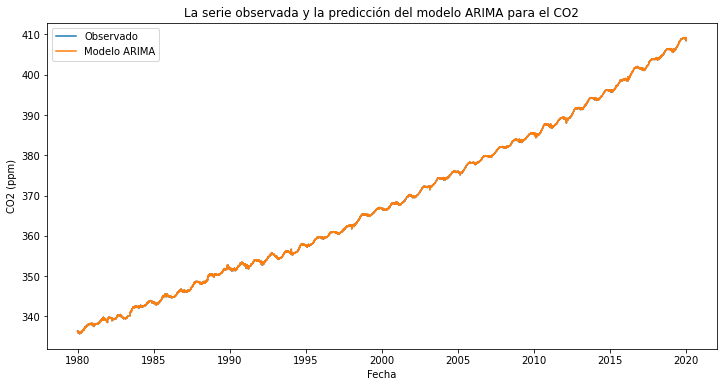

In [89]:
# Regresamos a la escala de Temperatura original 
predictions_ARIMA = 10**(predictions_ARIMA_log)
# Graficamos la serie original y las predicciones con ARIMA

# Tamaño de las gráficas
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(ts_80, label='Observado');
plt.plot(predictions_ARIMA, label='Modelo ARIMA');
plt.xlabel('Fecha')
plt.ylabel('CO2 (ppm)')
plt.title('La serie observada y la predicción del modelo ARIMA para el CO2')
plt.legend(loc='best');

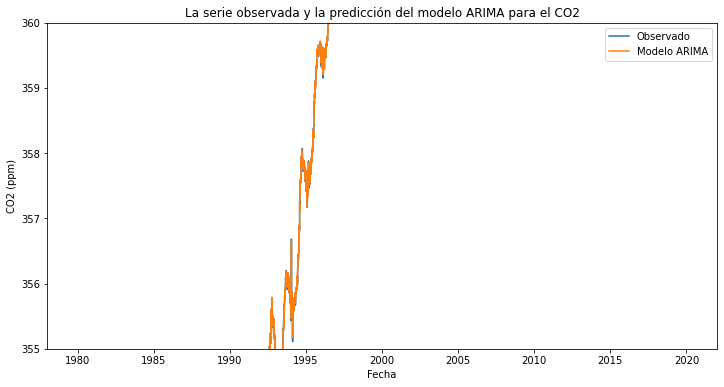

In [90]:
# Acercamos la gráfica

# Tamaño de las gráficas
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(ts_80, label='Observado');
plt.plot(predictions_ARIMA, label='Modelo ARIMA');
plt.xlabel('Fecha')
plt.ylabel('CO2 (ppm)')
plt.ylim(355,360)
plt.title('La serie observada y la predicción del modelo ARIMA para el CO2')
plt.legend(loc='best');

Casi no se aprecia la gráfica observada, al estar tapada por la predicción podemos decir que es buena.

* Calcula el error RMSE


In [94]:
# Calculamos el RMSE (Root Mean Square Error - Error de la Raiz Cuadrada de la Media)

RMSE = np.sqrt(np.mean((predictions_ARIMA - ts_80)**2))
print('RMSE:', RMSE)

RMSE: 0.018899244271053547


* Por último contrasta los 5 últimos años de la Serie de CO2 y el modelo ARIMA para ver mas a detalles el modelo.

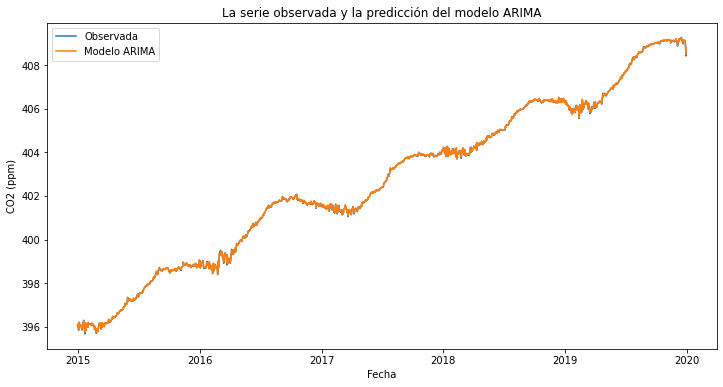

In [92]:
# Graficamos sólo los útimos datos de las series 
# 365*5+2=1827 datos para 5 años (más dos días de los años bisiestos)
ts_test_last = ts_80.tail(1827)
predictions_ARIMA_last = predictions_ARIMA.tail(1827)
plt.plot(ts_test_last, label='Observada');
plt.plot(predictions_ARIMA_last, label='Modelo ARIMA');
plt.xlabel('Fecha')
plt.ylabel('CO2 (ppm)')
plt.title('La serie observada y la predicción del modelo ARIMA')
plt.legend(loc='best');

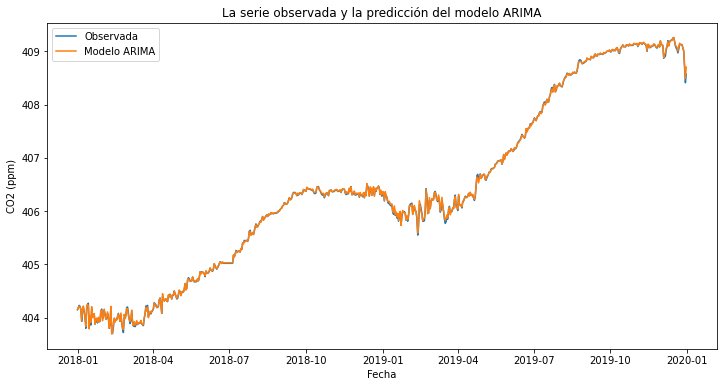

In [93]:
# Graficamos sólo los útimos datos de las series 
# DATOS PARA 2 años, más zoom.
ts_test_last = ts_80.tail(731)
predictions_ARIMA_last = predictions_ARIMA.tail(731)
plt.plot(ts_test_last, label='Observada');
plt.plot(predictions_ARIMA_last, label='Modelo ARIMA');
plt.xlabel('Fecha')
plt.ylabel('CO2 (ppm)')
plt.title('La serie observada y la predicción del modelo ARIMA')
plt.legend(loc='best');

Aún haciendo zoom a los dísa analizados (5 y 2 años) no se puede apreciar bien devido a que la predicción del ARIMA se sobrepone a la Observada. Esto, aunado al error de 0.018 nos indica que la predicción es muy buena, esto se veía venir desde que el valor de p era muy pequeño. Sin duada el método ARIMA es muy poderoso y con el correcto tratamiento de los datos se puden a llegar conclusiones interesantes, como el obvio aumento de CO2 a través de los años. 